In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20180919205632-0000


### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2018-09-19 20:56:35--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2018-09-19 20:56:35 (15.4 MB/s) - 'loan_train.csv' saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date']=pd.to_datetime(df['due_date'])
df['effective_date']=pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



See how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/ibm/conda/miniconda3

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2018.03.07 |                0         124 KB  anaconda
    openssl-1.0.2p             |       h14c3975_0         3.5 MB  anaconda
    certifi-2018.8.24          |           py35_1         139 KB  anaconda
    conda-4.5.11               |           py35_0         1.0 MB  anaconda
    seaborn-0.9.0              |           py35_0         378 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.1 MB

The following packages will be UPDATED:

    ca-certificates: 2017.08.26-h1d4fec5_0 --> 2018.03.07-0      anaconda
    certifi:         2018.1.18-py35_0      --> 2018.8.24-py35_1  anaconda
    conda:           

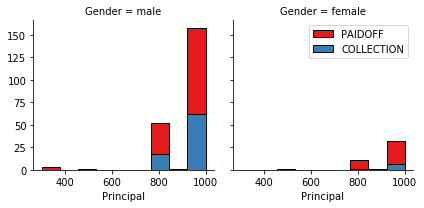

In [8]:
import seaborn as sns

bins=np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

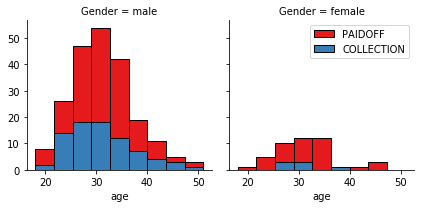

In [9]:
bins=np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Look at the day of the week people get the loan 

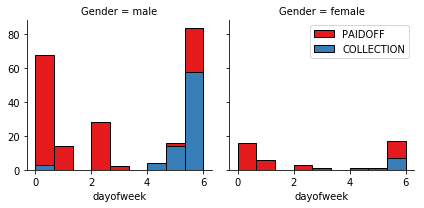

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins=np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


People who get the loan at the end of the week don't pay it off

In [11]:
df['weekend']= df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=False)

Gender  loan_status
female  PAIDOFF         45
        COLLECTION       7
male    PAIDOFF        215
        COLLECTION      79
Name: loan_status, dtype: int64

Convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


  
#### On education

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


In [17]:
Feature=df[['Principal','terms','age','Gender','weekend']]
Feature=pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You can find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [28]:
# import KNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score


In [29]:
cols =['Algorithm', 'Jaccard', 'F1-Score', 'LogLoss']
accu_matrix=pd.DataFrame([['kNN', 0,0, 'NA'], 
                          ['Decision Tree',0,0,'NA'],
                          ['SVM',0,0,'NA'],
                         ['Logistic Regression',0,0,'NA']], columns=cols)
accu_matrix = accu_matrix.set_index('Algorithm')

In [30]:
X_trainKNN, X_testKNN, y_trainKNN, y_testKNN = train_test_split(X, y, test_size=0.2, random_state=0)
print ('Train set:', X_trainKNN.shape,  y_trainKNN.shape)
print ('Test set:', X_testKNN.shape,  y_testKNN.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [33]:
# to find the best K
Ks = 10
mean_accuracy = np.zeros((Ks -1))
std_accuracy = np.zeros((Ks-1))

for n in range(1, Ks):
    # Train model and predict
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_trainKNN, y_trainKNN)
    yhat = neigh.predict(X_testKNN)
    mean_accuracy[n-1] = metrics.accuracy_score(y_testKNN, yhat)
    
    std_accuracy[n-1] = np.std(yhat==y_testKNN)/np.sqrt(yhat.shape[0])

mean_accuracy

array([ 0.65714286,  0.57142857,  0.7       ,  0.67142857,  0.71428571,
        0.68571429,  0.75714286,  0.72857143,  0.75714286])

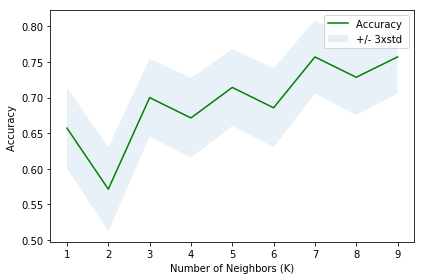

In [34]:
# PLot model accuracy with different number of neighbors
plt.plot(range(1, Ks), mean_accuracy, 'g')
plt.fill_between(range(1,Ks), mean_accuracy - 1 * std_accuracy, mean_accuracy + 1 * std_accuracy, alpha=0.1)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [31]:
# Finds out what the best value for K is.
print( "The best accuracy was with", mean_accuracy.max(), "with k=", mean_accuracy.argmax()+1) 

The best accuracy was with 0.757142857143 with k= 7


In [67]:
KNN_f1_score =f1_score(y_testKNN, yhat_KNN, average='weighted')

TypeError: Expected sequence or array-like, got estimator KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

In [68]:
neigh7 = KNeighborsClassifier(n_neighbors = 7).fit(X_trainKNN, y_trainKNN)

In [69]:
yhat7_KNN = neigh7.predict(X_testKNN)

In [71]:
KNN_f1_Score = f1_score(y_testKNN, yhat7_KNN, average='weighted')

In [70]:
KNN_jaccard = jaccard_similarity_score(y_testKNN, yhat7_KNN)

In [36]:
k = 7 
# Train model and Predict
loan_KNN = KNeighborsClassifier(n_neighbors=k).fit(X, y)
loan_KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')

# Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

In [38]:
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [39]:
X

array([[ 0.51578458,  0.92071769,  2.33152555, ..., -0.38170062,
         1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148, ...,  2.61985426,
        -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, ..., -0.38170062,
        -0.87997669,  1.14984679],
       ..., 
       [-1.31458942, -0.95911111,  1.33661351, ..., -0.38170062,
        -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188, ..., -0.38170062,
        -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.81902922, ..., -0.38170062,
        -0.87997669,  1.14984679]])

In [40]:
X_trainDT, X_testDT, y_trainDT, y_testDT = train_test_split(X, y, test_size=0.2, random_state=0)


In [41]:
LoanTree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
LoanTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
LoanTree.fit(X_trainDT, y_trainDT)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [57]:
yhat_DT = LoanTree.predict(X_testDT)

In [60]:
dt_f1_score = f1_score(y_testDT, yhat_DT, average='weighted')

In [61]:
dt_jaccard = jaccard_similarity_score(y_testDT, yhat_DT)

In [62]:
# checking accuracy
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testDT, yhat_DT))

DecisionTrees's Accuracy:  0.714285714286


# Support Vector Machine

In [49]:
Feature.dtypes

Principal               int64
terms                   int64
age                     int64
Gender                  int64
weekend                 int64
Bechalor                uint8
High School or Below    uint8
college                 uint8
dtype: object

In [46]:
X_trainSVM, X_testSVM, y_trainSVM, y_testSVM = train_test_split(X, y, test_size=0.2, random_state=0)


In [48]:
from sklearn import svm
loan_SVM = svm.SVC(kernel='rbf')
loan_SVM.fit(X_trainSVM, y_trainSVM)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [50]:
yhat_SVM = loan_SVM.predict(X_testSVM)

In [52]:
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [55]:
svm_f1_score = f1_score(y_testSVM, yhat_SVM, average='weighted') 

In [56]:
svm_jaccard = jaccard_similarity_score(y_testSVM, yhat_SVM)

# Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
X_trainLR, X_testLR, y_trainLR, y_testLR = train_test_split(X, y, test_size=0.2, random_state=0)


In [76]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_trainLR,y_trainLR)

In [77]:
yhat_LR = LR.predict(X_testLR)

In [78]:
yhat_prob_LR = LR.predict_proba(X_testLR)


In [79]:
LR_jaccard = jaccard_similarity_score(y_testLR, yhat_LR)

In [81]:
LR_f1_score = f1_score(y_testLR, yhat_LR, average='weighted') 

# Model Evaluation using Test set

First, download and load the test set:

In [62]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2018-09-19 03:46:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2018-09-19 03:46:46 (515 MB/s) - 'loan_test.csv' saved [3642/3642]



### Load Test set for evaluation 

In [63]:
df = pd.read_csv('loan_test.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [82]:
accu_matrix

,Jaccard,F1-Score,LogLoss
Algorithm,,,
kNN,0,0,NA
Decision Tree,0,0,NA
SVM,0,0,NA
Logistic Regression,0,0,NA


In [87]:
accu_matrix.set_value('kNN',['Jaccard','F1-Score'],[KNN_f1_Score, KNN_jaccard])

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


,Jaccard,F1-Score,LogLoss
Algorithm,,,
kNN,0.760944,0.757143,NA
Decision Tree,0.000000,0.000000,NA
SVM,0.000000,0.000000,NA
Logistic Regression,0.000000,0.000000,NA


In [91]:
accu_matrix.loc['Decision Tree',['Jaccard','F1-Score']] = [dt_f1_score,dt_jaccard]

In [92]:
accu_matrix

,Jaccard,F1-Score,LogLoss
Algorithm,,,
kNN,0.760944,0.757143,NA
Decision Tree,0.742825,0.714286,NA
SVM,0.000000,0.000000,NA
Logistic Regression,0.000000,0.000000,NA


In [93]:
accu_matrix.loc['SVM',['Jaccard','F1-Score']] = [svm_f1_score,svm_jaccard]

In [94]:
accu_matrix

,Jaccard,F1-Score,LogLoss
Algorithm,,,
kNN,0.760944,0.757143,NA
Decision Tree,0.742825,0.714286,NA
SVM,0.714286,0.714286,NA
Logistic Regression,0.000000,0.000000,NA


In [100]:
from sklearn.metrics import log_loss
logLoss_LR=log_loss(y_testLR, yhat_prob_LR)


In [101]:
accu_matrix.loc['Logistic Regression',['Jaccard','F1-Score', 'LogLoss']] = [LR_f1_score,LR_jaccard,logLoss_LR]

In [102]:
accu_matrix

,Jaccard,F1-Score,LogLoss
Algorithm,,,
kNN,0.760944,0.757143,NA
Decision Tree,0.742825,0.714286,NA
SVM,0.714286,0.714286,NA
Logistic Regression,0.756452,0.800000,0.539572


## Want to learn more?

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: [SPSS Modeler](http://cocl.us/ML0101EN-SPSSModeler).

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at [Watson Studio](https://cocl.us/ML0101EN_DSX)


<hr>
Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>